### Import libraries

In [19]:
# import statements
%load_ext autoreload
%autoreload 2

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate data

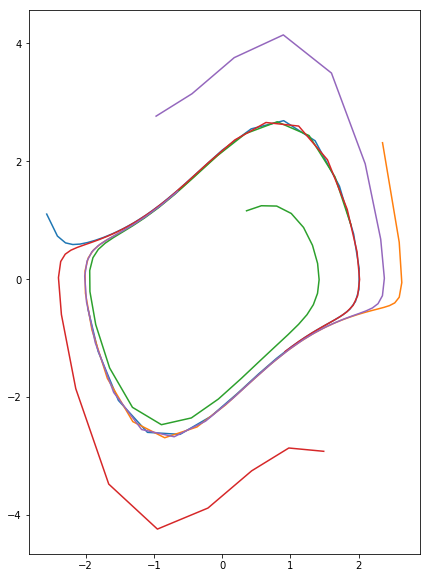

In [20]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], (1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
t = torch.linspace(0., 7., 40)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1
    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')

## Implementation-1, gradients computed via sensitivities (uses autograd as a subroutine) 

### Initialize the model, parameters, variables, etc

In [36]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
Linv = torch.cholesky(K(Zt,Zt)).inverse()
U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        N = x0.shape[0]  # problem dimensionality
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
                x = xS[:,:,0].view(-1,D) # N,D
                S = xS[:,:,1:] # N,D,MD
                th = list(func.parameters())[0]
                dxs = []
                dSs = []
                for j in range(N):
                    x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
                    S_ = S[j] # D,MD
                    J = [] # accumulate columns of J here
                    R = [] # accumulate columns of R here
                    for i in range(D): # partial derivative of output dimension i 
                        with torch.set_grad_enabled(True):
                            f = func(t,x_)[0,i]
                            dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
                            J.append(dfdxth[0])
                            R.append(dfdxth[1].view(1,-1)) # 1,MD
                    J = torch.cat(J) # D,D
                    R = torch.cat(R) # D,MD
                    dS = torch.matmul(J,S_)+R # D,MD
                    dx = func(t,x_) # 1,D
                    dxs.append(dx.unsqueeze(2)) # 1,D,1
                    dSs.append(dS.unsqueeze(0)) # 1,D,MD
                dx = torch.cat(dxs) # N,D,1
                dS = torch.cat(dSs) # N,D,MD
                dxdS = torch.cat([dx,dS],2)
                return dxdS
            x0 = torch.unsqueeze(x0,2) # N,D,1
            S0 = torch.zeros(N,D,MD)
            xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
            xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
            # print(grad_output[0].shape) # N,T,D
            dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    

### Optimize

In [39]:
# optimization

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)

    
for itr in range(500):
    optimizer.zero_grad()
    T   = min(3+itr//10, len(t))
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint_forw_sens(kreg,x0,t_)
    loss = torch.sum((Yt_-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt_)*torch.sum(logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),kreg.U)))/2
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


Iter 0000 | Total Loss 18.432181
Iter 0001 | Total Loss 16.313157
Iter 0002 | Total Loss 14.552110
Iter 0003 | Total Loss 12.595668
Iter 0004 | Total Loss 10.710499
Iter 0005 | Total Loss 8.941761
Iter 0006 | Total Loss 7.078394
Iter 0007 | Total Loss 5.153466
Iter 0008 | Total Loss 3.293931
Iter 0009 | Total Loss 1.481470
Iter 0010 | Total Loss -0.365379
Iter 0011 | Total Loss -2.224744
Iter 0012 | Total Loss -4.044138


KeyboardInterrupt: 

### Visualize

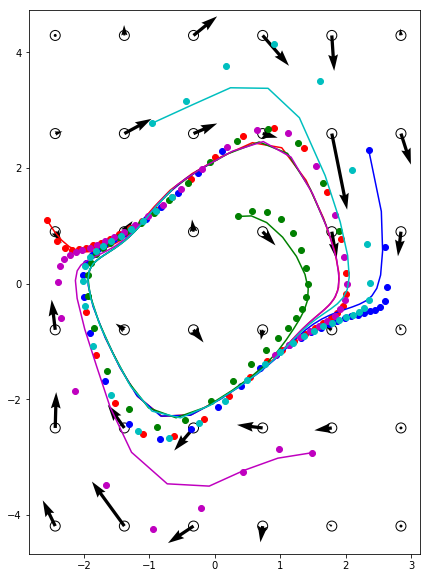

In [38]:
# plotting
xode = odeint_forw_sens(kreg, x0, t).detach().numpy()
U = kreg.U.detach().numpy()
Z = Zt.detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Implementation-2 that uses Torch autograd, no sensitivities/adjoints 

### Initialize the model, parameters, variables, etc

In [4]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

npode = KernelRegression()
lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
optimizer = optim.Adam(npode.parameters(), lr=5e-3)


### Optimize

In [9]:
# optimization
# def closure():
#     optimizer.zero_grad()
#     xode = odeint(npode, x0, t).permute([1,0,2])
#     loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
#     loss.backward()
#     return loss
    
for itr in range(500):
    optimizer.zero_grad()
    xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D + \
        torch.sum(torch.diag(torch.mm(npode.U.t(),npode.U)))/2
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
            loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

Iter 0000 | Total Loss 0.184906
Iter 0001 | Total Loss 0.161216
Iter 0002 | Total Loss 0.139271
Iter 0003 | Total Loss 0.119217
Iter 0004 | Total Loss 0.101184
Iter 0005 | Total Loss 0.085273
Iter 0006 | Total Loss 0.071540
Iter 0007 | Total Loss 0.059992
Iter 0008 | Total Loss 0.050586
Iter 0009 | Total Loss 0.043235
Iter 0010 | Total Loss 0.037808
Iter 0011 | Total Loss 0.034134
Iter 0012 | Total Loss 0.031997
Iter 0013 | Total Loss 0.031142
Iter 0014 | Total Loss 0.031272
Iter 0015 | Total Loss 0.032058
Iter 0016 | Total Loss 0.033160
Iter 0017 | Total Loss 0.034249
Iter 0018 | Total Loss 0.035042
Iter 0019 | Total Loss 0.035333
Iter 0020 | Total Loss 0.035010
Iter 0021 | Total Loss 0.034061
Iter 0022 | Total Loss 0.032561
Iter 0023 | Total Loss 0.030649
Iter 0024 | Total Loss 0.028503
Iter 0025 | Total Loss 0.026309
Iter 0026 | Total Loss 0.024238
Iter 0027 | Total Loss 0.022428
Iter 0028 | Total Loss 0.020967
Iter 0029 | Total Loss 0.019893
Iter 0030 | Total Loss 0.019193
Iter 003

KeyboardInterrupt: 

### Visualize

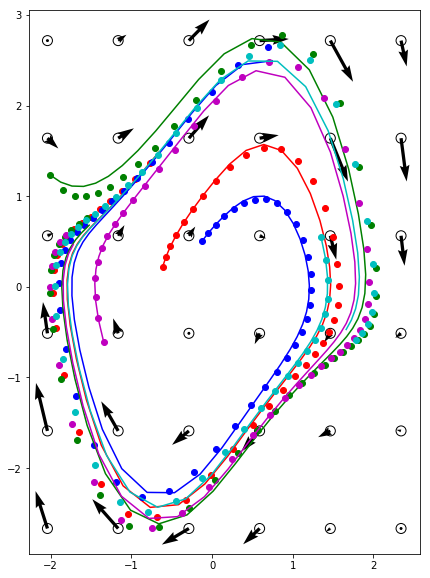

In [10]:
# plotting
xode = odeint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(X[i,:,0],X[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

## Old stuff

In [180]:
# working
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
# F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
# F_ = F_.contiguous().view(-1,D)
# Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
# Kxz = K(Zt,Z_)
# Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
# U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
# Linv = torch.cholesky(K(Zt,Zt)).inverse()
# U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS):
                x = xS[0:D].view(-1,D).detach().requires_grad_(True)
                S = xS[D:].view(D,MD)
                th = list(func.parameters())[0]
                J = [] # accumulate columns of J here
                R = [] # accumulate columns of R here
                for i in range(D): # partial derivative of output dimension i 
                    with torch.set_grad_enabled(True):
                        f = func(t,x)[0,i]
                        dfdxth = torch.autograd.grad(f, [x,th], allow_unused=False, retain_graph=False)
                        J.append(dfdxth[0])
                        R.append(dfdxth[1])
                J = torch.cat(J)  # D,D
                R = torch.cat([r.view(1,-1) for r in R]) # D,MD
                dS = torch.matmul(J,S)+R
                dx = func(t,x)[0]
                dxdS = torch.cat((dx.view(-1),dS.view(-1)))
                return dxdS
            S0 = torch.zeros(D,MD)
            xS0 = torch.cat((x0.view(-1),S0.view(-1)),0)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,1,(D+DMD)
            xode2 = xS[:,0:2].unsqueeze(0) # 1,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,2:].t().view(D,MD,-1).permute([0,2,1]) # D,T,MD
            dlossdx = grad_output[0][0].t().unsqueeze(2) # D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    
logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)
    
for itr in range(500):
    optimizer.zero_grad()
    xode = odeint_forw_sens(kreg,x0,t)
    loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


Iter 0000 | Total Loss 98.751462
Iter 0001 | Total Loss 97.419913
Iter 0002 | Total Loss 96.248658
Iter 0003 | Total Loss 95.244840
Iter 0004 | Total Loss 94.401635
Iter 0005 | Total Loss 93.693553
Iter 0006 | Total Loss 93.078331
Iter 0007 | Total Loss 92.507539
Iter 0008 | Total Loss 91.938668
Iter 0009 | Total Loss 91.343844
Iter 0010 | Total Loss 90.712634
Iter 0011 | Total Loss 90.049027
Iter 0012 | Total Loss 89.365532
Iter 0013 | Total Loss 88.677275
Iter 0014 | Total Loss 87.997541
Iter 0015 | Total Loss 87.335111
Iter 0016 | Total Loss 86.693393
Iter 0017 | Total Loss 86.071097
Iter 0018 | Total Loss 85.463947
Iter 0019 | Total Loss 84.866687
Iter 0020 | Total Loss 84.274682
Iter 0021 | Total Loss 83.684730
Iter 0022 | Total Loss 83.095073
Iter 0023 | Total Loss 82.504925
Iter 0024 | Total Loss 81.913927
Iter 0025 | Total Loss 81.321684
Iter 0026 | Total Loss 80.727463
Iter 0027 | Total Loss 80.130076
Iter 0028 | Total Loss 79.528027
Iter 0029 | Total Loss 78.919912
Iter 0030 

Iter 0249 | Total Loss -28.126093
Iter 0250 | Total Loss -28.534726
Iter 0251 | Total Loss -28.899954
Iter 0252 | Total Loss -29.225442
Iter 0253 | Total Loss -29.522498
Iter 0254 | Total Loss -29.810159
Iter 0255 | Total Loss -30.075780


KeyboardInterrupt: 